In [1]:
import torch, torchvision, os, glob, random, PIL, cv2, time
import warnings 
warnings.filterwarnings('ignore')

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [4]:
CFG={'SEED' : 42,
     'IMAGE_SIZE' : 224,
     'EPOCHS' : 40,
     'BATCH_SIZE' : 64,
     'LR' : 0.00001,
     'model_load_path1' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Color_Jitter.pt",
     'model_load_path2' : f"/home/user1/바탕화면/HJ/AICOSS 2023 (Pnuemonia)/Codes/Histogram_Equalization.pt"}

In [5]:
seed_everything(CFG['SEED'])

In [6]:
def get_path(path):
    normal=[]
    vir=[]
    bact=[]

    normal_label = []
    vir_label = []
    bact_label = []

    for t in os.listdir(path):
        if t=='NORMAL':
            normal_path = f"{path}{t}/"
            for normal_data in glob.glob(normal_path + "/*.jpeg"):
                normal.append(normal_data)
                normal_label.append(np.array([1,0,0]))

        elif t=='VIRUS':
            vir_path = f"{path}{t}/"
            for vir_data in glob.glob(vir_path + "/*.jpeg"):
                vir.append(vir_data)
                vir_label.append(np.array([0,1,0]))
                
        elif t=='BACTERIA':
            bact_path = f"{path}{t}/"
            for bact_data in glob.glob(bact_path + "/*.jpeg"):
                bact.append(bact_data)
                bact_label.append(np.array([0,0,1]))

    return normal, vir, bact, normal_label, vir_label, bact_label

#Train
train_path = f"/home/user1/바탕화면/HJ/chest_xray/train/"
train_normal, train_vir, train_bact, train_normal_label, train_vir_label, train_bact_label = get_path(train_path)

# Test
test_path = f"/home/user1/바탕화면/HJ/chest_xray/test/"
test_normal, test_vir, test_bact, test_normal_label, test_vir_label, test_bact_label = get_path(test_path)

In [7]:
print(f"Train Normal : {len(train_normal)}\nTrain Virus : {len(train_vir)}\nTrain Bacteria : {len(train_bact)}\n")
print(f"Test normal : {len(test_normal)}\nTest Virus : {len(test_vir)}\nTest Bacteria : {len(test_bact)}\n")

Train Normal : 1341
Train Virus : 1345
Train Bacteria : 2530

Test normal : 234
Test Virus : 148
Test Bacteria : 242



In [8]:
train_data = train_normal + train_vir + train_bact
train_label = train_normal_label + train_vir_label + train_bact_label

train_aug = train_normal + train_vir
train_aug_label = train_normal_label + train_vir_label

test_data = test_normal + test_vir + test_bact
test_label = test_normal_label + test_vir_label + test_bact_label

In [9]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

aug_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.ToTensor()
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE'])),
    torchvision.transforms.ToTensor()
])

In [10]:
class Cropdataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img(self, path):
        img = cv2.imread(path)  # ndarray 형태로 반환

        return img
    
    def __crop__(self, img):
        dimension = len(img.shape)
    
        if dimension == 2:
            h,w = img.shape
        else:
            h,w,_ = img.shape
    
        crop_h = int(0.9 * h)
        crop_w = int(0.85 * w)  # 가로 길이로는 조금 더 crop 해보기 (쓸데 없는 뼈는 학습하지 않도록)
    
        if dimension == 2:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w]
        else:
            cropped_image = img[h-crop_h : crop_h, w-crop_w : crop_w, :]
    
        return cropped_image  # ndarray 반환

    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img(path)  # ndarray 반환
        img = self.__crop__(img)  # ndarray 반환
        R = cv2.equalizeHist(img[:, :, 0])
        G = cv2.equalizeHist(img[:, :, 1])
        B = cv2.equalizeHist(img[:, :, 2])
        img = PIL.Image.fromarray(cv2.merge((R, G, B)))

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.from_numpy(label)

In [11]:
train_crop_dataset = Cropdataset(train_data, train_label, train_transform)  # t_c_dataset: [IMAGE, LABEL]
train_aug_dataset = Cropdataset(train_aug, train_aug_label, aug_transform)  # t_a_dataset: [IMAGE, LABEL]
train_dataset = train_crop_dataset + train_aug_dataset
train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [12]:
img, label = next(iter(train_dataloader))

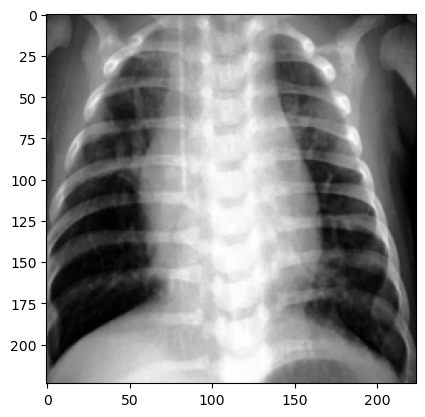

In [13]:
# len(train_dataloader.dataset)  # 7902개의 이미지
from torchvision.transforms.functional import to_pil_image
sample = to_pil_image(img[15])
plt.imshow(sample)

In [14]:
print(f"Image shape : {img[0].shape}")
print(f"Label Shape : {label[0].shape}")

Image shape : torch.Size([3, 224, 224])
Label Shape : torch.Size([3])


In [15]:
import timm

class Model(nn.Module):
    def __init__(self, classes=3):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True)
        self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.model(x)
        x = self.softmax(x)

        return x

In [16]:
model1 = Model()
model1 = nn.DataParallel(model1).to(device)
model2 = Model()
model2 = nn.DataParallel(model2).to(device)

In [17]:
test_crop_dataset = Cropdataset(test_data, test_label, test_transform)
test_aug_dataset = Cropdataset(test_vir, test_vir_label, aug_transform)
test_dataset = test_crop_dataset + test_aug_dataset
test_dataloader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

In [18]:
def ensemble_test(dataloader, model1, model2, model_path1, model_path2):
    model1.load_state_dict(torch.load(model_path1))
    model2.load_state_dict(torch.load(model_path2))
    model1.eval()
    model2.eval()

    pred_normal=[]
    pred_virus=[]
    pred_bacteria=[]
    label_normal=[]
    label_virus=[]
    label_bacteria=[]
    
    label=[]
    pred=[]

    for (X, y) in dataloader:
        for t in y:
            label.append(t.detach().tolist())
            label_normal.append(t[0].detach().tolist())
            label_virus.append(t[1].detach().tolist())
            label_bacteria.append(t[2].detach().tolist())

        X = X.to(device).float()
        y = y.to(device).float()

        output1 = model1(X)
        output2 = model2(X)
        output = (output1 + output2) / 2

        for o in output:
            pred.append(o.detach().cpu().tolist())
            pred_normal.append(o[0].detach().cpu().tolist())
            pred_virus.append(o[1].detach().cpu().tolist())
            pred_bacteria.append(o[2].detach().cpu().tolist())

    return label_normal, label_virus, label_bacteria, pred_normal, pred_virus, pred_bacteria, np.array(label), np.array(pred)

In [19]:
n_label, v_label, b_label, n_pred, v_pred, b_pred, label, pred = ensemble_test(test_dataloader, model1, model2, CFG['model_load_path1'], CFG['model_load_path2'])

<Axes: >

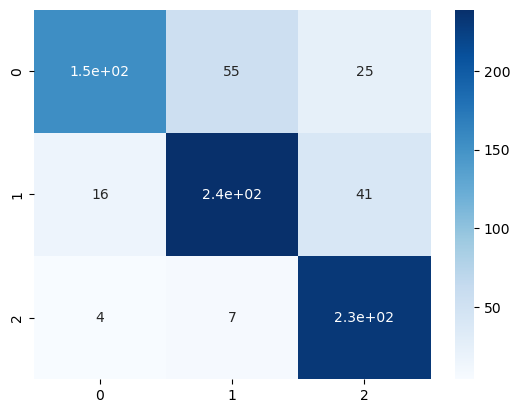

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns

OH_pred = []

for vector in pred:
    OH_pred.append(np.argmax(vector, axis=0))

OH_label = []

for vector in label:
    OH_label.append(np.argmax(vector, axis=0))

cm = confusion_matrix(OH_label, OH_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [21]:
def correct_count(pred, label):  # Model이 n/v/b를 각각 몇 개씩 실제로 맞췄는지
    total = len(pred)  # Test 데이터 개수
    n_correct = 0
    v_correct = 0
    b_correct = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if (pred_idx == label_idx):
            if pred_idx == 0:  # Normal
                n_correct += 1
            elif pred_idx == 1:  # Virus
                v_correct += 1
            elif pred_idx == 2:  # Bacteria
                b_correct += 1
    
    return n_correct, v_correct, b_correct

In [22]:
def nvb_size(label):
    total = len(label)
    total_n = 0
    total_v = 0
    total_b = 0

    for idx in range(total):
        now = label[idx]
        if now[0] == 1:
            total_n += 1
        elif now[1] == 1:
            total_v += 1
        elif now[2] == 1:
            total_b += 1
        
    return total_n, total_v, total_b

In [23]:
total_n, total_v, total_b = nvb_size(label)
n_correct, v_correct, b_correct = correct_count(pred, label)

total = total_n + total_v + total_b
total_correct = n_correct + v_correct + b_correct

n_sens = n_correct/total_n
v_sens = v_correct/total_v
b_sens = b_correct/total_b

print(f"Normal Sensitivity: {n_sens}")
print(f"Virus Sensitivity: {v_sens}")
print(f"Bacteria Sensitivity: {b_sens}\n")
print(f"Test Accuracy: {total_correct/total}")

Normal Sensitivity: 0.6581196581196581
Virus Sensitivity: 0.8074324324324325
Bacteria Sensitivity: 0.9545454545454546

Test Accuracy: 0.8082901554404145


In [24]:
def calc_spec(pred, label):
    total = len(pred)  # Test 데이터 개수
    n_FP = 0
    v_FP = 0
    b_FP = 0

    for idx in range(total):
        pred_idx = np.argmax(pred[idx], axis=0)
        label_idx = np.argmax(label[idx], axis=0)

        if pred_idx == 0 and label_idx != 0:
            n_FP += 1
        elif pred_idx == 1 and label_idx != 1:
            v_FP += 1
        elif pred_idx == 2 and label_idx != 2:
            b_FP += 1
        
    n_TN = total - total_n - n_FP
    v_TN = total - total_v - v_FP
    b_TN = total - total_b - b_FP

    n_spec = n_TN/(n_TN + n_FP)
    v_spec = v_TN/(v_TN + v_FP)
    b_spec = b_TN/(b_TN + b_FP)
    
    return n_spec, v_spec, b_spec

In [25]:
n_spec, v_spec, b_spec = calc_spec(pred, label)

print(f"Normal Specificity: {n_spec}")
print(f"Virus Specificity: {v_spec}")
print(f"Bacteria Specificity: {b_spec}")

Normal Specificity: 0.9628252788104089
Virus Specificity: 0.8697478991596639
Bacteria Specificity: 0.8754716981132076


In [26]:
def pred_count(pred):  # Model이 n/v/b로 각각 몇 개씩 분류했는지 (오분류된 데이터가 포함된 개수)
    n_pred = 0
    v_pred = 0
    b_pred = 0
    for p in pred:
        idx = np.argmax(p) # 예측 확률이 가장 높은 인덱스 (0: Normal, 1: Virus, 2: Bacteria)
        if idx == 0:
            n_pred += 1
        elif idx == 1:
            v_pred += 1
        else:
            b_pred += 1
    return n_pred, v_pred, b_pred

In [27]:
n_pred_total, v_pred_total, b_pred_total = pred_count(pred)

In [28]:
n_precision = n_correct/n_pred_total
v_precision = v_correct/v_pred_total
b_precision = b_correct/b_pred_total

In [29]:
def f1_score(precision, recall):
    return 2*(precision*recall)/(precision+recall)

In [30]:
n_f1 = f1_score(n_precision, n_sens)
v_f1 = f1_score(v_precision, v_sens)
b_f1 = f1_score(b_precision, b_sens)

print(f"Normal F1-score: {n_f1}")
print(f"Virus F1-score: {v_f1}")
print(f"Bacteria F1-score: {b_f1}")

Normal F1-score: 0.7549019607843137
Virus F1-score: 0.8006700167504187
Bacteria F1-score: 0.8571428571428572
